# Anime Recommendation using LightGBM Learning to Rank

In [14]:
from tqdm import tqdm 
tqdm.pandas()

In [1]:
import sys 
import os 
import gc 
import random 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split

import lightgbm as lgb
import optuna
import warnings 
warnings.simplefilter('ignore')

SEED = 2021

def seed_all(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_all(SEED)

/home/niranjan/miniconda3/envs/anime_recommender/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Data

In [2]:
anime = pd.read_csv("./data/anime.csv")
rating = pd.read_csv("./data/rating_complete.csv")

In [3]:
print(f"""
anime: shape:{anime.shape}
anime_num: {len(anime.MAL_ID.unique())}
"""
)
anime.info()
anime.head(2)


anime: shape:(17562, 35)
anime_num: 17562

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [4]:
print(f"""
rating: shape:{rating.shape}
user_num: {len(rating.user_id.unique())}
anime_num: {len(rating.anime_id.unique())}
""")
rating.info()
rating.head()


rating: shape:(57633278, 3)
user_num: 310059
anime_num: 16872

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57633278 entries, 0 to 57633277
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 1.3 GB


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [5]:
# rating dataset is large so samples some records
rating = rating.sample(frac=0.1)

print(f"""
sampled rating
shape:{rating.shape}
user_num: {len(rating.user_id.unique())}
anime_num: {len(rating.anime_id.unique())}
""")


sampled rating
shape:(5763328, 3)
user_num: 285834
anime_num: 15617



In [6]:
# use anime features
anime_features = ['MAL_ID','English name','Japanese name','Score','Genres','Popularity','Members',
            'Favorites','Watching','Completed','On-Hold','Dropped',
            'Score-1','Score-2','Score-3','Score-4','Score-5',
            'Score-6','Score-7','Score-8','Score-9','Score-10',
           ]
print("No. of used anime features : ", len(anime_features))
anime = anime[anime_features]
anime.head()

No. of used anime features :  22


,MAL_ID,English name,Japanese name,Score,Genres,Popularity,Members,Favorites,Watching,Completed,...,Score-1,Score-2,Score-3,Score-4,Score-5,Score-6,Score-7,Score-8,Score-9,Score-10
0,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,1580.0,741.0,1357.0,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0
1,5,Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,8.39,"Action, Drama, Mystery, Sci-Fi, Space",518,273145,1174,4143,208333,...,379.0,109.0,221.0,577.0,1877.0,5805.0,22632.0,49505.0,49201.0,30043.0
2,6,Trigun,トライガン,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",201,558913,12944,29113,343492,...,533.0,316.0,664.0,1965.0,5838.0,15376.0,49432.0,86142.0,75651.0,50229.0
3,7,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.27,"Action, Mystery, Police, Supernatural, Drama, ...",1467,94683,587,4300,46165,...,131.0,164.0,353.0,1083.0,2920.0,5709.0,11618.0,10128.0,4806.0,2182.0
4,8,Beet the Vandel Buster,冒険王ビィト,6.98,"Adventure, Fantasy, Shounen, Supernatural",4369,13224,18,642,7314,...,27.0,50.0,83.0,265.0,634.0,1068.0,1713.0,1242.0,529.0,312.0


In [7]:
# merge anime and rating
merged_df = anime.merge(rating, left_on="MAL_ID", right_on="anime_id", how="inner")
print(merged_df.shape)
merged_df.head()

(5763328, 25)


,MAL_ID,English name,Japanese name,Score,Genres,Popularity,Members,Favorites,Watching,Completed,...,Score-4,Score-5,Score-6,Score-7,Score-8,Score-9,Score-10,user_id,anime_id,rating
0,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0,19180,1,10
1,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0,193024,1,9
2,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0,112160,1,9
3,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0,155191,1,10
4,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,3184.0,8904.0,20688.0,62330.0,131625.0,182126.0,229170.0,74372,1,10


In [8]:
del anime 
del rating 
gc.collect()

0

### Preprocess

In [9]:
merged_df.columns

Index(['MAL_ID', 'English name', 'Japanese name', 'Score', 'Genres',
       'Popularity', 'Members', 'Favorites', 'Watching', 'Completed',
       'On-Hold', 'Dropped', 'Score-1', 'Score-2', 'Score-3', 'Score-4',
       'Score-5', 'Score-6', 'Score-7', 'Score-8', 'Score-9', 'Score-10',
       'user_id', 'anime_id', 'rating'],
      dtype='object')

In [17]:
genre_names = [
    'Action', 'Adventure','Comedy',
    'Slice of Life','Drama','Sci-Fi',
    'Game','Harem','Military','Space','Music', 'Mecha',
     'Historical', 'Mystery', 'School', 'Hentai', 'Fantasy', 'Horror',
     'Kids', 'Sports', 'Magic', 'Romance', 
]


def genre_to_category(df):
    '''
    Add genre category column
    '''
    d = {name: [] for name in genre_names}

    def f(row):
        genres = row.Genres.split(',')
        for genre in genre_names:
            if genre in genres:
                d[genre].append(1)
            else:
                d[genre].append(0)
    
    # create genre category dict
    df.progress_apply(f, axis=1)

    # add genre category
    genre_df = pd.DataFrame(d, columns=genre_names)
    df = pd.concat([df, genre_df], axis=1)
    return df 

def make_anime_feature(df):
    # convert object to numeric type, replacing unknwon with nan.
    print("converting score to float")
    df["Score"] = df["Score"].apply(lambda x: np.nan if x == "Unknown" else float(x))

    for i in range(1, 11):
        df[f'Score-{i}'] = df[f'Score-{i}'].apply(lambda x: np.nan if x=='Unknown' else float(x))
    print("convert genre to category")
    # add genre category column
    df = genre_to_category(df)
    return df 

def make_user_feature(df):
    # add user feature
    df["rating_count"] = df.groupby('user_id')['anime_id'].transform('count')
    df['rating_mean'] = df.groupby('user_id')['rating'].transform('mean')
    return df 

def preprocess(merged_df):
    merged_df = make_anime_feature(merged_df)
    print("make user feature")
    merged_df = make_user_feature(merged_df)
    return merged_df

In [18]:
merged_df = preprocess(merged_df)
merged_df.head()

converting score to float
convert genre to category


100%|██████████| 5763328/5763328 [00:54<00:00, 105116.89it/s]


make user feature


,MAL_ID,English name,Japanese name,Score,Genres,Popularity,Members,Favorites,Watching,Completed,...,School,Hentai,Fantasy,Horror,Kids,Sports,Magic,Romance,rating_count,rating_mean
0,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,9,7.666667
1,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,16,7.687500
2,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,8,7.125000
3,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,35,7.314286
4,1,Cowboy Bebop,カウボーイビバップ,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",39,1251960,61971,105808,718161,...,0,0,0,0,0,0,0,0,14,8.500000


### Split data

In [19]:
train, test = train_test_split(merged_df, test_size=0.2, random_state=SEED)
gc.collect()

1752

In [20]:
print('train shape: ',train.shape)
print('test shape: ',test.shape)

train shape:  (4610662, 49)
test shape:  (1152666, 49)


In [21]:
features = ['Score', 'Popularity','Members',
            'Favorites','Watching','Completed','On-Hold','Dropped',
            'Score-1','Score-2','Score-3','Score-4','Score-5',
            'Score-6','Score-7','Score-8','Score-9','Score-10',
            'rating_count','rating_mean'
           ]
features += genre_names

user_col = 'user_id'
item_col = 'anime_id'
target_col = 'rating'

In [22]:
train = train.sort_values('user_id').reset_index(drop=True)
test = test.sort_values('user_id').reset_index(drop=True)

In [26]:
train.head()

,MAL_ID,English name,Japanese name,Score,Genres,Popularity,Members,Favorites,Watching,Completed,...,School,Hentai,Fantasy,Horror,Kids,Sports,Magic,Romance,rating_count,rating_mean
0,570,Jin-Roh:The Wolf Brigade,人狼 JIN-ROH,7.79,"Military, Police, Psychological, Drama, Romance",1181,124856,1359,3005,72439,...,0,0,0,0,0,0,0,0,2,7.000
1,39547,My Teen Romantic Comedy SNAFU Climax!,やはり俺の青春ラブコメはまちがっている。完,8.46,"Slice of Life, Comedy, Drama, Romance, School",343,390621,12632,49455,199414,...,0,0,0,0,0,0,0,0,8,8.125
2,936,Naruto the Movie 2:Legend of the Stone of Gelel,劇場版 NARUTO 大激突！幻の地底遺跡だってばよ,6.88,"Adventure, Comedy, Drama, Fantasy, Shounen, Su...",864,172509,203,1276,159598,...,0,0,0,0,0,0,0,0,8,8.125
3,31043,ERASED,僕だけがいない街,8.37,"Mystery, Psychological, Supernatural, Seinen",29,1359119,37017,52888,1071295,...,0,0,0,0,0,0,0,0,8,8.125
4,40776,Unknown,ハイキュー!! TO THE TOP,8.57,"Comedy, Sports, Drama, School, Shounen",375,355906,4333,66566,194898,...,0,0,0,0,0,0,0,0,8,8.125


In [23]:
# model query data
train_query = train[user_col].value_counts().sort_index()
test_query = test[user_col].value_counts().sort_index()

In [41]:
from lightgbm import early_stopping
early_stopping_callback = early_stopping(stopping_rounds=50, verbose=True)

In [42]:
# try parameter training
def objective(trial):
    # search param
    param = {
        'reg_alpha': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1), 
        #'subsample': trial.suggest_uniform('subsample', 1e-8, 1), 
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100), 
    }

    # train model
    model = lgb.LGBMRanker(n_estimators = 100, **param, objective="lambdarank", random_state=SEED)

    model.fit(
        train[features],
        train[target_col], 
        group=train_query, 
        eval_set = [(test[features], test[target_col])], 
        eval_group = [list(test_query)], 
        eval_metric = "ndcg",
        eval_at = [1, 3, 5, 10, 20],  # calculate the validation ndcg@1, 3, 5, 10, 20
        callbacks = [early_stopping_callback, ]
    )

    # maximize mean ndcg
    scores = []
    for name, score in model.best_score_['valid_0'].items():
        scores.append(score)
    return np.mean(scores)

In [43]:
study = optuna.create_study(direction='maximize', 
                            sampler = optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=3)

[I 2024-06-27 15:17:12,009] A new study created in memory with name: no-name-a854baa7-bf3b-4261-8969-ff730051d778


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5102
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

[I 2024-06-27 15:17:26,529] Trial 0 finished with value: 0.9009843966736698 and parameters: {'lambda_l1': 0.002843181006784031, 'lambda_l2': 0.03984045142951022, 'max_depth': 3, 'num_leaves': 81, 'colsample_bytree': 0.9975189532062868, 'min_child_samples': 17}. Best is trial 0 with value: 0.9009843966736698.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	valid_0's ndcg@1: 0.828143	valid_0's ndcg@3: 0.891708	valid_0's ndcg@5: 0.915509	valid_0's ndcg@10: 0.9324	valid_0's ndcg@20: 0.937162
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5102
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-06-27 15:17:44,654] Trial 1 finished with value: 0.9015614092912886 and parameters: {'lambda_l1': 4.082610550411722e-07, 'lambda_l2': 0.059748754831459396, 'max_depth': 6, 'num_leaves': 201, 'colsample_bytree': 0.18720495633237474, 'min_child_samples': 10}. Best is trial 1 with value: 0.9015614092912886.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[93]	valid_0's ndcg@1: 0.829167	valid_0's ndcg@3: 0.892299	valid_0's ndcg@5: 0.916013	valid_0's ndcg@10: 0.932808	valid_0's ndcg@20: 0.93752
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5102
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-06-27 15:18:01,791] Trial 2 finished with value: 0.9009401865215425 and parameters: {'lambda_l1': 4.587371497704769, 'lambda_l2': 0.0035401119417365744, 'max_depth': 3, 'num_leaves': 145, 'colsample_bytree': 0.6548722377561911, 'min_child_samples': 97}. Best is trial 1 with value: 0.9015614092912886.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[93]	valid_0's ndcg@1: 0.828225	valid_0's ndcg@3: 0.891615	valid_0's ndcg@5: 0.915435	valid_0's ndcg@10: 0.932332	valid_0's ndcg@20: 0.937094


In [44]:
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

Number of finished trials: 3
Best trial: {'lambda_l1': 4.082610550411722e-07, 'lambda_l2': 0.059748754831459396, 'max_depth': 6, 'num_leaves': 201, 'colsample_bytree': 0.18720495633237474, 'min_child_samples': 10}


In [68]:
print(features)
train[features].head()

['Score', 'Popularity', 'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped', 'Score-1', 'Score-2', 'Score-3', 'Score-4', 'Score-5', 'Score-6', 'Score-7', 'Score-8', 'Score-9', 'Score-10', 'rating_count', 'rating_mean', 'Action', 'Adventure', 'Comedy', 'Slice of Life', 'Drama', 'Sci-Fi', 'Game', 'Harem', 'Military', 'Space', 'Music', 'Mecha', 'Historical', 'Mystery', 'School', 'Hentai', 'Fantasy', 'Horror', 'Kids', 'Sports', 'Magic', 'Romance']


,Score,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Score-1,Score-2,...,Historical,Mystery,School,Hentai,Fantasy,Horror,Kids,Sports,Magic,Romance
0,7.79,1181,124856,1359,3005,72439,1078,612,113.0,131.0,...,0,0,0,0,0,0,0,0,0,0
1,8.46,343,390621,12632,49455,199414,7847,4490,597.0,280.0,...,0,0,0,0,0,0,0,0,0,0
2,6.88,864,172509,203,1276,159598,574,489,467.0,698.0,...,0,0,0,0,0,0,0,0,0,0
3,8.37,29,1359119,37017,52888,1071295,15132,11609,1785.0,1493.0,...,0,1,0,0,0,0,0,0,0,0
4,8.57,375,355906,4333,66566,194898,5135,1942,389.0,82.0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# train with best params
best_params = study.best_trial.params
model = lgb.LGBMRanker(n_estimators=1000, **best_params, random_state=SEED,)
model.fit(
        train[features],
        train[target_col], 
        group=train_query, 
        eval_set = [(test[features], test[target_col])], 
        eval_group = [list(test_query)], 
        eval_metric = "ndcg",
        eval_at = [1, 3, 5, 10, 20],  # calculate the validation ndcg@1, 3, 5, 10, 20
        callbacks = [early_stopping_callback, ]
)

[LightGBM] [Warning] lambda_l2 is set=0.059748754831459396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.059748754831459396
[LightGBM] [Warning] lambda_l1 is set=4.082610550411722e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.082610550411722e-07
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l2 is set=0.059748754831459396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.059748754831459396
[LightGBM] [Warning] lambda_l1 is set=4.082610550411722e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.082610550411722e-07
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5102
[LightGBM] [Info] Number of data points in the train set: 4610662, number of used features: 42
[LightGBM] 

LGBMRanker(colsample_bytree=0.18720495633237474,
           lambda_l1=4.082610550411722e-07, lambda_l2=0.059748754831459396,
           max_depth=6, min_child_samples=10, n_estimators=1000, num_leaves=201,
           random_state=2021)

In [62]:
# check output values
model.predict(test.iloc[:10][features])

[LightGBM] [Warning] lambda_l2 is set=0.059748754831459396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.059748754831459396
[LightGBM] [Warning] lambda_l1 is set=4.082610550411722e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.082610550411722e-07


array([-0.65532187,  0.55117495, -0.97340766,  0.66115644,  0.60294367,
        0.26536733, -0.0588962 , -1.21049585, -1.51648184,  0.39471811])

Text(0.5, 1.0, 'feature importance')

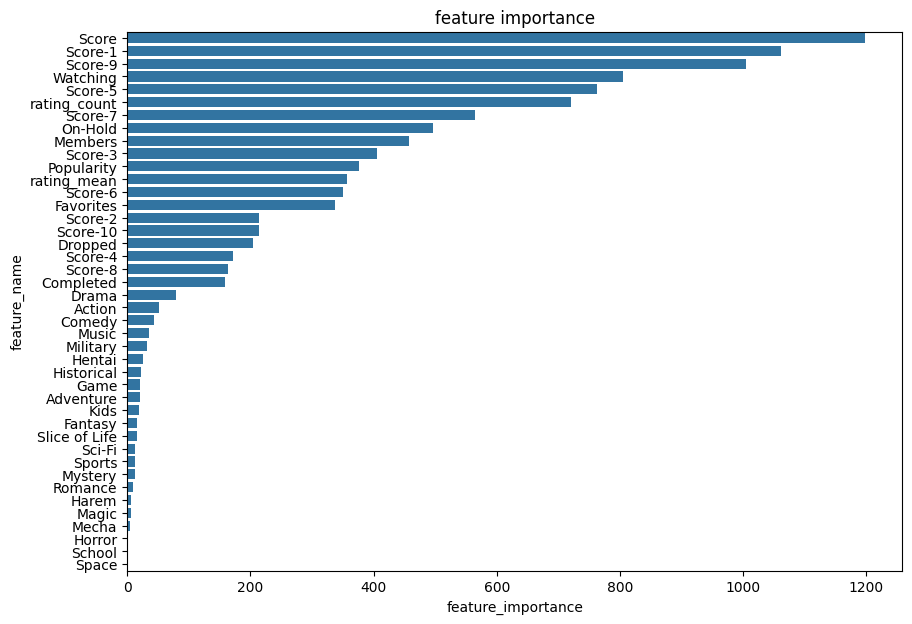

In [63]:
# feature imporance
plt.figure(figsize=(10, 7))
df_plt = pd.DataFrame({'feature_name': features, 'feature_importance': model.feature_importances_})
df_plt.sort_values('feature_importance', ascending=False, inplace=True)
sns.barplot(x="feature_importance", y="feature_name", data=df_plt)
plt.title('feature importance')

### Recommend for user

In [65]:
def recommend_for_user(user, model, k, sample_anime_num):
    anime = pd.read_csv("./data/anime.csv")
    # sample recommended candidate
    pred_df = anime.sample(sample_anime_num).reset_index(drop=True)
    rating = pd.read_csv("./data/rating_complete.csv")

    # preprocess for model prediction
    user_df = rating.query('user_id==@user')
    user_df = make_user_feature(user_df)
    for col in user_df.columns:
        if col in features:
            pred_df[col] = user_df[col].values[0]
    
    pred_df = make_anime_feature(pred_df)

    print("-"*10, "Dataframe for prediction input", "-" *10)
    display(pred_df.head())
    # recommend
    preds = model.predict(pred_df[features])
    topk_idx = np.argsort(preds)[::-1][:k]
    recommend_df = pred_df.loc[topk_idx].reset_index(drop=True)

    # check recommend
    print("-"*10, "Recommend","-" * 10)
    for i, row in recommend_df.iterrows():
        print(f'{i+1}: {row["Japanese name"]}:{row["English name"]}')
    
    print("-"*10, "Actual","-" * 10) 
    user_df = user_df.merge(anime, left_on='anime_id', right_on='MAL_ID', how='inner')
    for i, row in user_df.sort_values('rating',ascending=False).iterrows():
        print(f'rating:{row["rating"]}: {row["Japanese name"]}:{row["English name"]}') 
    
    return recommend_df



In [66]:
user = 20
k = 10
sample_anime_num = 1000
recommend_df = recommend_for_user(user, model, k, sample_anime_num)

converting score to float
convert genre to category


100%|██████████| 1000/1000 [00:00<00:00, 100479.22it/s]

---------- Dataframe for prediction input ----------


,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Historical,Mystery,School,Hentai,Fantasy,Horror,Kids,Sports,Magic,Romance
0,37751,Turning Mecard W: Vandyne-ui Bimil - Teugbyeolpan,NaN,"Adventure, Cars, Game, Kids, Mecha",Turning Mecard W:The Secret of Vandyne - Speci...,터닝메카드 W 반다인의 비밀 특별판,Movie,1,"Feb 8, 2018",Unknown,...,0,0,0,0,0,0,0,0,0,0
1,14367,Tenshi na Konamaiki Specials,6.07,Shounen,Cheeky Angel DVD Specials,天使な小生意気DVDスペシャル,Special,13,"Aug 21, 2002 to Aug 21, 2003",Unknown,...,0,0,0,0,0,0,0,0,0,0
2,26229,Kaze no Tabibito,NaN,"Drama, Kids",Unknown,風の旅人,OVA,1,2003,Unknown,...,0,0,0,0,0,0,0,0,0,0
3,37242,Hoshi to Tsubasa no Paradox,NaN,"Action, Sci-Fi, Mecha",Starwing Paradox,星と翼のパラドクス,ONA,2,"Feb 7, 2018 to Nov 7, 2018",Unknown,...,0,0,0,0,0,0,0,0,0,0
4,36111,Ima,NaN,Music,Now,今,Music,1,"Jun, 2017",Unknown,...,0,0,0,0,0,0,0,0,0,0


[LightGBM] [Warning] lambda_l2 is set=0.059748754831459396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.059748754831459396
[LightGBM] [Warning] lambda_l1 is set=4.082610550411722e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.082610550411722e-07
---------- Recommend ----------
1: あしたのジョー２:Rocky Joe 2
2: ハイキュー!! セカンドシーズン:Haikyu!! 2nd Season
3: 宇宙戦艦ヤマト2199:Star Blazers:Space Battleship Yamato 2199
4: ジョジョの奇妙な冒険 黄金の風:JoJo's Bizarre Adventure:Golden Wind
5: 機動戦士ガンダムTHE ORIGIN:Mobile Suit Gundam:The Origin
6: 夏目友人帳 参:Natsume's Book of Friends Season 3
7: 続 夏目友人帳:Natsume's Book of Friends Season 2
8: ハイキュー!! TO THE TOP:Unknown
9: ロミオの青い空:Romeo and the Black Brothers
10: メジャー 第6シリーズ:Unknown
---------- Actual ----------
rating:10: ハイキュー!! セカンドシーズン:Haikyu!! 2nd Season
rating:10: 幼女戦記:The Saga of Tanya the Evil
rating:10: 盾の勇者の成り上がり:The Rising of the Shield Hero
rating:10: 転生したらスライムだった件:That Time I Got Reincarnated as a Slime
rating:10: ハイキュー!! 烏野高校 VS 白鳥沢学園高校:Haik